This notebook analyses and visualizes Airbnb data in New Orleans. It shows the locations of listings by neighborhood and includes and interactive map where the user can click on listings and see the daily price. It also summarizes price by neighborhood, type of room, and type of property. 

In [51]:
#This definition creates a list out of the value of a defined column in the Airbnb csv file
def createList(attribute):
    
    #Import and open the csv file containing all the of Airbnb data
    openfile = open("listings.csv", encoding="utf8", newline = "")
    airbnb = csv.DictReader(openfile)
    
    #Create an empty list to be populated with data in a given column
    finder = []
    
    #Add data to 'finder'
    for bnb in airbnb:
        if bnb[attribute] not in finder:
            #print('yep')
            #print(bnb['room_type'])
            finder.append(bnb[attribute])
    
    #Return the populated list
    return finder

#This definition creates a dictionary that has the airbnb attributes sorted by a defined key    
def findIt(attribute, finder):
    
    #Create an empty dictionary with a key for each item in finder
    finderName = {key:[] for key in finder}
    
    #Create dictionary with nested keys to be populated with values
    finderDict = {key:{'price':[],'average':[],'maxprice':[],'minprice':[],'averageincome':[]} for key in finderName}
    
    #Import and open the csv file containing all of the Airbnb data
    openfile = open ("listings.csv", encoding="utf8",newline = "")
    airbnb = csv.DictReader(openfile)

    #Loop through airbnb data
    #When the key in the overall set of data matches the key in the finderDict, append the value
    for bnb in airbnb:
        for key in finderDict:
            if key == bnb[attribute]:
                
                #The following two lines remove special characters from the price values
                cleansedprice = bnb['price'].replace('$','') 
                cleansedprice = cleansedprice.replace(',','')
                
                #Listings of $0 are considered errors
                #Do if the listing is greater than $0, append the value
                if float(cleansedprice) > 0:
                    finderDict[key]['price'].append(float(cleansedprice))
    
    #Loop through keys in the finderDict
    #Find the minimum and maximum price for each key
    for key in finderDict:
        priceList = finderDict[key]['price']
        finderDict[key]['maxprice'].append(max(priceList))
        finderDict[key]['minprice'].append(min(priceList))
        aveofList = round(sum(finderDict[key]['price'])/len(finderDict[key]['price']), 2)
        finderDict[key]['average'].append(aveofList)
    
    #Return the dictionary created with the keys defined in the argument
    return finderDict

#Create list of property types
#Create dictionry with property types as keys
prop = createList('property_type')    
propDict = findIt('property_type', prop)

#Create list of room types
#Create dictionry with room types as keys
room = createList('room_type')
roomDict = findIt('room_type', room)

#Create list of neighborhood names
#Create dictionry with neighborhood names as keys
neighborhoods = createList('neighbourhood_cleansed')
neighborhoods = sorted(neighborhoods)
neighborhoodDict = findIt('neighbourhood_cleansed', neighborhoods)

#Create list of bed types
#Create dictionry with bed types as keys
beds = createList('bed_type')
bedDict = findIt('bed_type', beds)

#Create list of cancellation policies
#Create dictionry with cancellation policies as keys
cancel = createList('cancellation_policy')
cancelDict = findIt('cancellation_policy', cancel)

In [55]:
#Import fiona, folium, and json
import fiona
import folium
import json

#Load shapefile of the neighborhood census data
openHoods = fiona.open('neighborhoodsWincome.shp', 'r')

#Create a list of neighborhoods listed in the shapefile
hoodList = [] 
for hood in openHoods:
    hoodList.append(hood)

openHoods.close()

#Define the extent of the map
m = folium.Map(location = [30.003675, -90.077057], zoom_start=10)

#Loop through the neighborhoods in the csv file, and add them to the map
for item in hoodList:
    j = json.dumps(item['geometry'])
    folium.features.GeoJson(j).add_to(m)
    #print(item)

m

In [23]:
#Import matplotlib
import matplotlib.pyplot as plt

#Open shapefile with census data
income = fiona.open('neighborhoodsWincome.shp', 'r')

#this is the average income for an area
for i in income:
    for key in neighborhoodDict:
        if (i['properties']['GNOCDC_LAB']).lower() == key.lower(): 
            if len(neighborhoodDict[key]['averageincome']) < 1:
                if len(i['properties']['neworleans']) > 1:
                    floatVal = i['properties']['neworleans']
                    neighborhoodDict[key]['averageincome'].append(float(floatVal))
                else: 
                    neighborhoodDict[key]['averageincome'].append(0)
                
#print(neighborhoodDict)



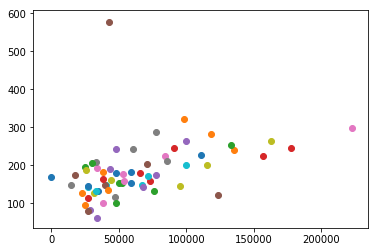

In [24]:
#This loops thorugh the neighborhoods and plots the average listing price against average income
for keys in neighborhoodDict:
    if len(neighborhoodDict[keys]['averageincome']) > 0:
        y = neighborhoodDict[keys]['average']
        x = neighborhoodDict[keys]['averageincome']
        plt.scatter(x,y)
plt.show()
    


In [25]:
#Install UTM
!pip install utm

import csv
from shapely.geometry import Point
from shapely.geometry import Polygon
import json
import shapely
import utm
import folium

In [26]:
openfile = open("listings.csv", encoding="utf8", newline = "")
airbnb = csv.DictReader(openfile)

#print(neighborhoodDict)

rentalID = []
for bnb in airbnb:
    rentalID.append(bnb['id'])

rentalKey = {key:{'price':[],'location':[], 'neighborhood':[]} for key in rentalID}

openfile = open("listings.csv", encoding="utf8", newline = "")
airbnb = csv.DictReader(openfile)
        
for bnb in airbnb:
    for key in rentalKey:
        if key == bnb[str('id')]:
            cleansedprice = bnb['price'].replace('$','')       #these next two lines clean the data, without them the prices are like this $1,000 
            cleansedprice = cleansedprice.replace(',','')
            rentalKey[key]['price'].append(float(cleansedprice))
            geometry= Point(float(bnb['longitude']), float(bnb['latitude']))
            points = utm.from_latlon(geometry.y,geometry.x)
            geomUTM = Point(points[0],points[1])
            rentalKey[key]['location'].append(geomUTM)
            rentalKey[key]['neighborhood'].append(bnb['neighbourhood_cleansed'])
            

In [27]:
def distanceFrom(minNum, maxNum):
    center = utm.from_latlon(29.957868,-90.066352)
    place = Point(center[0],center[1])
    print(place)
    
    #miles to meters
    minDist = minNum * 1609.34
    maxDist = maxNum * 1609.34
    #buffer place by minDist for the inner ring
    minBuff = place.buffer(minDist)
    #outer ring
    maxBuff = place.buffer(maxDist)
    
    #creates the map that this function makes
    mapBuffer = folium.Map(location = [29.957868,-90.066352], zoom_start=10)
    priceList = []
    for key in rentalKey:
        for UTM in rentalKey[key]['location']: 
        #if the point is within the big buffer but not in small buffer
            if UTM.within(maxBuff) is True:
                if UTM.within(minBuff) is False:
                    #this converts each point back to wgs1984
                    wgs = Point(utm.to_latlon(UTM.x,UTM.y, 15, 'R'))
                    for price in rentalKey[key]['price']:
                        priceList.append(price)
                        folium.Marker([wgs.x,wgs.y], popup = ('Price:$'+ str(price))).add_to(mapBuffer)
              
    #print(priceList)
    print('The max price in this buffer is:' , max(priceList))
    print('The min price in this buffer is:' , min(priceList))
    print('The average price in this buffer is:' , round(sum(priceList)/len(priceList),2))
    return mapBuffer

map2 = distanceFrom(2,2.25)
map2

POINT (783125.4628068339 3317738.318538894)
The max price in this buffer is: 9999.0
The min price in this buffer is: 20.0
The average price in this buffer is: 201.38


In [28]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

startDist = [0]
x = 0
while x < 6:
    x = x + .25
    startDist.append(x)

from IPython.display import display

def distOne(Buffer):
    return Buffer

a = interactive(distOne, Buffer=startDist)
display(a) 

#def distTwo(End):
#    return End

#b = interactive(distTwo, End=endDist)
#display(b) 


'0'

In [29]:
begin = float(a.result)
#finish = float(b.result)
finish = begin + 0.25

In [30]:
map4 = distanceFrom(begin,finish)
map4

POINT (783125.4628068339 3317738.318538894)
The max price in this buffer is: 2200.0
The min price in this buffer is: 0.0
The average price in this buffer is: 240.71


In [19]:
def withinNeighborhood(name):
    
    priceList = []
    mapNeighborhood = folium.Map(location = [29.957868,-90.066352], zoom_start=10)
    for key in rentalKey:
        for loc in rentalKey[key]['neighborhood']:
            if loc == name:
                for UTM in rentalKey[key]['location']: 
                    wgs = Point(utm.to_latlon(UTM.x,UTM.y, 15, 'R'))
                    for price in rentalKey[key]['price']:
                        priceList.append(price)
                        folium.Marker([wgs.x,wgs.y], popup = ('Price:$'+ str(price))).add_to(mapNeighborhood)
              
    #print(priceList)
    print('The max price in ' + name +' is', max(priceList))
    print('The min price in '+ name +' is', min(priceList))
    print('The average price in '+ name +' is', round(sum(priceList)/len(priceList),2))
    return mapNeighborhood

map3 = withinNeighborhood('Algiers Point')
map3



The max price in Algiers Point is 300.0
The min price in Algiers Point is 49.0
The average price in Algiers Point is 132.85


In [31]:
#Widget inspired by http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html
from IPython.display import display

#Create dropdown menu 
def makeMenu(Select):
    return Select

#Create interactive dropdown menu from list of neighborhoods
temp1 = interactive(makeMenu, Select=neighborhoods)
display(temp1) 

'Algiers Point'

In [32]:
neighborSelect = temp1.result

In [33]:
#Create interactive dropdown menu from list of room types
temp2 = interactive(makeMenu, Select=room)
display(temp2)

'Entire home/apt'

In [34]:
roomSelect = temp2.result

In [35]:
#Create interactive dropdown menu from list of property types
temp3 = interactive(makeMenu, Select=prop)
display(temp3)

'Townhouse'

In [36]:
propSelect = temp3.result

In [37]:
#Create interactive dropdown menu from list of bed types
temp4 = interactive(makeMenu, Select=beds)
display(temp4)

'Real Bed'

In [38]:
bedSelect = temp4.result

In [39]:
#Create interactive dropdown menu from list of cancellation policies
temp5 = interactive(makeMenu, Select=cancel)
display(temp5)

'flexible'

In [50]:
cancelSelect = temp5.result

In [56]:
#This definition prints out the min, mav, and average price for the given Airbnb attribute
def getData(dictionary, selection):
    for key in dictionary:
        if key == selection:
            print('')
            print('Data for', selection)
            print('Average price: $', dictionary[key]['average'][0])
            print('Minimum price: $', dictionary[key]['minprice'][0])
            print('Maximum price: $', dictionary[key]['maxprice'][0])

#Get pricing information by neighborhood
getData(neighborhoodDict, neighborSelect)

#Get pricing information by room type
getData(roomDict, roomSelect)

#Get pricing information by property type
getData(propDict, propSelect)

#Get pricing information by bed type
getData(bedDict, bedSelect)

#Get pricing information by cancellation policy
getData(cancelDict, cancelSelect)


Data for Algiers Point
Average price: $ 132.85
Minimum price: $ 49.0
Maximum price: $ 300.0

Data for Entire home/apt
Average price: $ 228.79
Minimum price: $ 12.0
Maximum price: $ 5000.0

Data for Townhouse
Average price: $ 322.98
Minimum price: $ 32.0
Maximum price: $ 7000.0

Data for Real Bed
Average price: $ 201.8
Minimum price: $ 12.0
Maximum price: $ 9999.0

Data for flexible
Average price: $ 209.04
Minimum price: $ 10.0
Maximum price: $ 9999.0
